In [37]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time
from tqdm import tqdm
import seaborn as sns

import matplotlib.ticker as mticker           # Optional: you can print out y axis labels as dollars. 
import numpy as np
import pandas as pd
import gc
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

In [38]:

# Define the folder path
folder_path = 'datasets/nfl-big-data-bowl-2023.zip'
extract_path = 'datasets/nfl-big-data-bowl-2023'

# Check if the extraction directory already exists
if not os.path.exists(extract_path):
    # Unzip the file
    with zipfile.ZipFile(folder_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted all files to {extract_path}")
else:
    print(f"Directory {extract_path} already exists, skipping extraction.")

# List all CSV files in the folder
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]

# Initialize an empty dictionary to store dataframes
dataframes = {}

# Load each CSV file as a separate dataframe with a progress bar
for file in tqdm(csv_files, desc="Loading CSV files", unit="file"):
    file_path = os.path.join(extract_path, file)
    df_name = os.path.splitext(file)[0]
    dataframes[df_name] = pd.read_csv(file_path)

# Convert dictionary to global variables
for key, df in dataframes.items():
    globals()[key] = df

# Display the keys of the dataframes dictionary to verify
print("Loaded DataFrames:", list(dataframes.keys()))

Directory datasets/nfl-big-data-bowl-2023 already exists, skipping extraction.


Loading CSV files: 100%|██████████| 12/12 [00:04<00:00,  2.45file/s]

Loaded DataFrames: ['week1', 'week2', 'week3', 'pffScoutingData', 'plays', 'week7', 'week6', 'week4', 'week5', 'players', 'games', 'week8']


In [39]:
# concat all motion data
all_weeks = pd.concat([week1, week2, week3, week4, week5, week6, week7, week8], ignore_index=True)
all_weeks = all_weeks.merge(players[['nflId', 'displayName', 'officialPosition']], on='nflId', how='left')

# group all motion data by gameId, playId, nflId, displayName, officialPosition, then calculate mean, max, std of s, a, x, y
motion_df = all_weeks.groupby(['gameId', 'playId', 'nflId', 'displayName', 'officialPosition']).agg({
    's': ['mean', 'max', 'std'],
    'a': ['mean', 'max', 'std'],
    'x': ['min', 'max', 'mean'],
    'y': ['min', 'max', 'mean']
})

# flatten the multi-level columns
motion_df = motion_df.reset_index()
motion_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in motion_df.columns.values]

# Merge pffScoutingData into motion_df
motion_df = motion_df.merge(pffScoutingData, on=['gameId', 'playId', 'nflId'], how='left')
motion_df = motion_df.merge(plays, on=['gameId', 'playId'], how='left')
ol = ['C', 'G', 'T', 'TE']
dl = ['DL', 'LB', 'DE', 'OLB', 'ILB', 'NT', 'MLB']
motion_df['OL'] = motion_df['officialPosition'].apply(lambda x: 1 if x in ol else 0)
motion_df['DL'] = motion_df['officialPosition'].apply(lambda x: 1 if x in dl else 0)

#create separate dataframes for OL and DL
ol_motion_df = motion_df[motion_df['OL'] == 1].copy()
dl_motion_df = motion_df[motion_df['DL'] == 1].copy()

In [40]:
ol_motion_df.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'officialPosition',
       's_mean', 's_max', 's_std', 'a_mean', 'a_max', 'a_std', 'x_min',
       'x_max', 'x_mean', 'y_min', 'y_max', 'y_mean', 'pff_role',
       'pff_positionLinedUp', 'pff_hit', 'pff_hurry', 'pff_sack',
       'pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed',
       'pff_sackAllowed', 'pff_nflIdBlockedPlayer', 'pff_blockType',
       'pff_backFieldBlock', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult', 'foulName1',
       'foulNFLId1', 'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3',
       'absoluteYardlineNumber', 'offenseFormation', 'personnelO',
       'defendersInBox', 'personnelD', 'dropBackType', 'pff_playAction',
       'pff_passCoverage', 'pff_passCoverageType', 'OL', 'DL'],
 

In [41]:
all_weeks.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,displayName,officialPosition
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,NaN,Tom Brady,QB
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,NaN,Tom Brady,QB
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,NaN,Tom Brady,QB
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,NaN,Tom Brady,QB
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,NaN,Tom Brady,QB


In [42]:
ol_roster = players[players['officialPosition'].isin(ol)]
dl_roster = players[players['officialPosition'].isin(dl)]

In [43]:
ol_ids = ol_roster['nflId'].unique()
dl_ids = dl_roster['nflId'].unique()
all_weeks['OL'] = all_weeks['nflId'].apply(lambda x: 1 if x in ol_ids else 0)
all_weeks['DL'] = all_weeks['nflId'].apply(lambda x: 1 if x in dl_ids else 0)

In [44]:
ol_weeks = all_weeks[all_weeks['OL'] == 1].copy()
dl_weeks = all_weeks[all_weeks['DL'] == 1].copy()
ol_weeks = ol_weeks.drop(columns=['OL', 'DL'])
dl_weeks = dl_weeks.drop(columns=['OL', 'DL'])
ol_weeks.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,displayName,officialPosition
43,2021090900,97,35481.0,1,2021-09-10T00:26:31.100,87.0,TB,right,41.08,29.15,0.31,0.43,0.03,35.96,238.77,NaN,Rob Gronkowski,TE
44,2021090900,97,35481.0,2,2021-09-10T00:26:31.200,87.0,TB,right,41.34,29.45,0.38,1.02,0.40,102.09,29.56,NaN,Rob Gronkowski,TE
45,2021090900,97,35481.0,3,2021-09-10T00:26:31.300,87.0,TB,right,41.53,29.39,0.61,1.10,0.20,68.16,71.57,NaN,Rob Gronkowski,TE
46,2021090900,97,35481.0,4,2021-09-10T00:26:31.400,87.0,TB,right,41.53,29.38,0.53,0.76,0.01,73.06,82.44,NaN,Rob Gronkowski,TE
47,2021090900,97,35481.0,5,2021-09-10T00:26:31.500,87.0,TB,right,41.54,29.36,0.97,1.52,0.03,76.60,75.14,NaN,Rob Gronkowski,TE


In [45]:
ol_weeks

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,displayName,officialPosition
43,2021090900,97,35481.0,1,2021-09-10T00:26:31.100,87.0,TB,right,41.08,29.15,0.31,0.43,0.03,35.96,238.77,NaN,Rob Gronkowski,TE
44,2021090900,97,35481.0,2,2021-09-10T00:26:31.200,87.0,TB,right,41.34,29.45,0.38,1.02,0.40,102.09,29.56,NaN,Rob Gronkowski,TE
45,2021090900,97,35481.0,3,2021-09-10T00:26:31.300,87.0,TB,right,41.53,29.39,0.61,1.10,0.20,68.16,71.57,NaN,Rob Gronkowski,TE
46,2021090900,97,35481.0,4,2021-09-10T00:26:31.400,87.0,TB,right,41.53,29.38,0.53,0.76,0.01,73.06,82.44,NaN,Rob Gronkowski,TE
47,2021090900,97,35481.0,5,2021-09-10T00:26:31.500,87.0,TB,right,41.54,29.36,0.97,1.52,0.03,76.60,75.14,NaN,Rob Gronkowski,TE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8313883,2021110100,4433,52507.0,54,2021-11-02T03:20:26.500,74.0,NYG,right,21.51,26.75,2.05,0.37,0.22,55.95,32.20,NaN,Matt Peart,T
8313884,2021110100,4433,52507.0,55,2021-11-02T03:20:26.600,74.0,NYG,right,21.63,26.97,2.32,0.56,0.25,55.95,29.88,NaN,Matt Peart,T
8313885,2021110100,4433,52507.0,56,2021-11-02T03:20:26.700,74.0,NYG,right,21.75,27.19,2.45,0.44,0.25,55.95,28.44,NaN,Matt Peart,T
8313886,2021110100,4433,52507.0,57,2021-11-02T03:20:26.800,74.0,NYG,right,21.88,27.45,2.64,0.59,0.28,55.16,27.04,NaN,Matt Peart,T


In [46]:
def visualize_field_heatmap(player_df, xbins=13, ybins=6, annotate=False):
    """
    Visualize a heatmap showing the most visited areas of the football field.

    Args:
        player_df (DataFrame): DataFrame containing 'x' and 'y' coordinates of player positions.
        xbins (int): Number of horizontal bins (field lengthwise).
        ybins (int): Number of vertical bins (field widthwise).
        annotate (bool): Whether to annotate the heatmap cells with counts.
    """
    # Create bin edges
    x = np.linspace(0, 120, xbins)
    y = np.linspace(0, 53, ybins)
    
    # Initialize empty heatmap grid
    hmap = np.zeros((xbins, ybins))
    
    # Count points in each grid cell
    for i in range(xbins - 1):
        for j in range(ybins - 1):
            hmap[i, j] = len(
                player_df[
                    (player_df.x >= x[i]) & (player_df.x <= x[i + 1]) &
                    (player_df.y >= y[j]) & (player_df.y <= y[j + 1])
                ]
            )

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(
        np.transpose(hmap),  # Transpose to match field orientation
        annot=annotate,
        fmt='.0f',
        cmap='coolwarm',     # Optional: change color map for better field feel
        ax=ax
    )
    
    ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
    plt.xlabel('Field Length (yards)')
    plt.ylabel('Field Width (yards)')
    plt.show()


In [47]:
def visualize_field_heatmap(player_df, xbins=120, ybins=53, annotate=False):
    """
    Visualize a heatmap showing the most visited areas of the football field.
    Uses 1-yard resolution bins by default.
    """
    x = np.linspace(0, 120, xbins + 1)
    y = np.linspace(0, 53.3, ybins + 1)

    hmap = np.zeros((xbins, ybins))

    for i in range(xbins):
        for j in range(ybins):
            hmap[i, j] = len(
                player_df[
                    (player_df.x >= x[i]) & (player_df.x < x[i + 1]) &
                    (player_df.y >= y[j]) & (player_df.y < y[j + 1])
                ]
            )

    fig, ax = plt.subplots(figsize=(12, 6.5))  # more field-like ratio
    sns.heatmap(
        np.transpose(hmap),  # match field layout
        annot=annotate,
        fmt='.0f',
        cmap='Greens',
        ax=ax
    )

    ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
    plt.xlabel('Field Length (yards)')
    plt.ylabel('Field Width (yards)')
    plt.show()


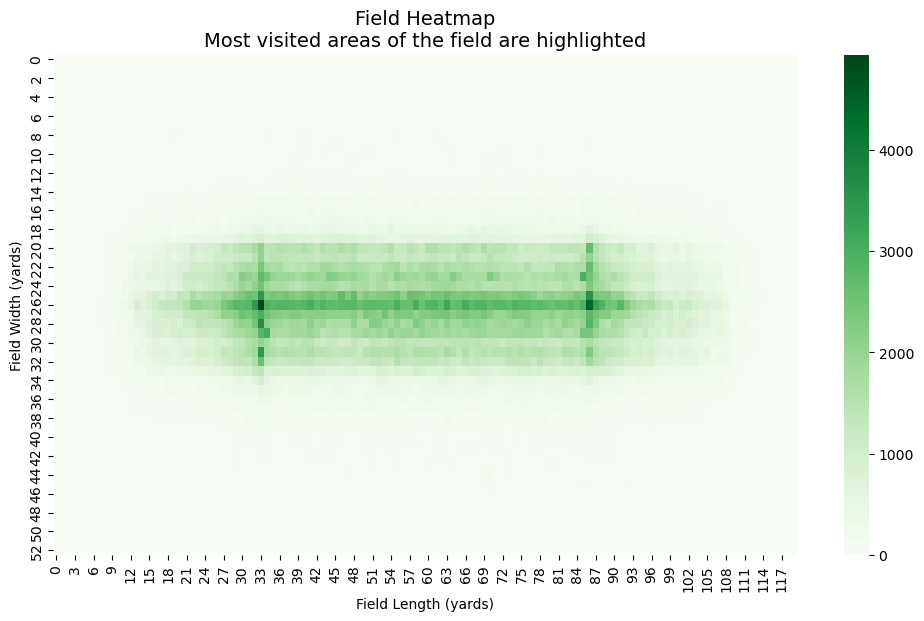

In [48]:
visualize_field_heatmap(ol_weeks)

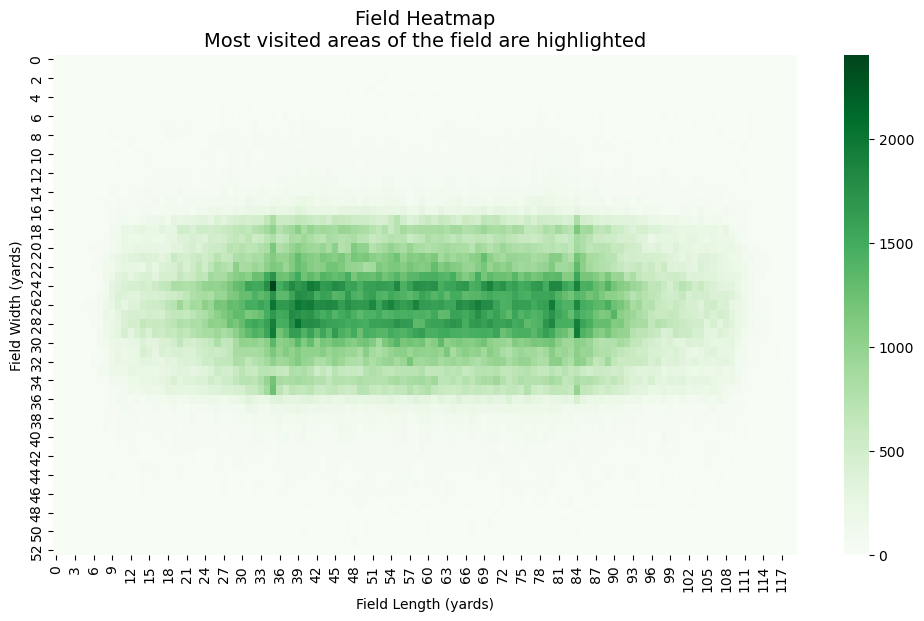

In [49]:
visualize_field_heatmap(dl_weeks)

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def visualize_field_heatmap_with_motion(
    player_df,
    xbins=120,
    ybins=53,
    cmap="Greens",
    ax=None
):
    """
    Heatmap of the football field (120×53.3 yards) with motion vectors and position labels.
    
    player_df must have columns: 'x', 'y', 'gameId', 'playId', 'nflId', 'frameId', 'officialPosition'.
    If ax is None, creates its own figure/axes; otherwise draws on the provided ax.
    """
    # 1. Compute 2D histogram
    heat, y_edges, x_edges = np.histogram2d(
        player_df['y'], player_df['x'],
        bins=[ybins, xbins],
        range=[[0, 53.3], [0, 120]]
    )
    
    # 2. Create axes if needed
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6.5))
        created_fig = True

    # 3. Draw turf heatmap
    sns.heatmap(
        heat,
        cmap=cmap,
        cbar_kws={'label': 'Occupancy Count'},
        xticklabels=False,
        yticklabels=False,
        ax=ax
    )
    ax.invert_yaxis()

    # 4. Yard‐line grid and labels
    x_ticks = np.linspace(0, xbins, 13)      # 0,10,20,...,120
    y_ticks = np.linspace(0, ybins, 6)       # 0, ~10.66, ... 53.3
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
    ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)
    ax.grid(which='major', color='white', linewidth=1.5)
    ax.grid(which='minor', visible=False)

    ax.set_xlabel('Field Length (yards)', fontsize=12)
    ax.set_ylabel('Field Width (yards)', fontsize=12)
    if created_fig:
        ax.set_title('Field Heatmap + Motion Vectors', fontsize=14)

    # 5. Compute motion vectors per player
    motion_df = (
        player_df
        .sort_values(['gameId', 'playId', 'nflId', 'frameId'])
        .groupby(['gameId', 'playId', 'nflId'])
        .agg({
            'x': ['first', 'last'],
            'y': ['first', 'last'],
            'officialPosition': 'first'
        })
        .reset_index()
    )
    motion_df.columns = [
        'gameId','playId','nflId',
        'x_start','x_end','y_start','y_end','officialPosition'
    ]
    motion_df['dx'] = motion_df['x_end'] - motion_df['x_start']
    motion_df['dy'] = motion_df['y_end'] - motion_df['y_start']
    motion_df['x_mid'] = (motion_df['x_start'] + motion_df['x_end']) / 2
    motion_df['y_mid'] = (motion_df['y_start'] + motion_df['y_end']) / 2

    # 6. Draw arrows
    ax.quiver(
        motion_df['x_mid'], motion_df['y_mid'],
        motion_df['dx'], motion_df['dy'],
        color='blue', scale_units='xy', angles='xy', scale=1.5, width=0.0025
    )

    # 7. Label positions
    for _, row in motion_df.iterrows():
        ax.text(
            row['x_mid'] + 0.5, row['y_mid'] + 0.5,
            row['officialPosition'],
            fontsize=8, color='black', weight='bold'
        )

    if created_fig:
        plt.tight_layout()
        plt.show()

    return ax

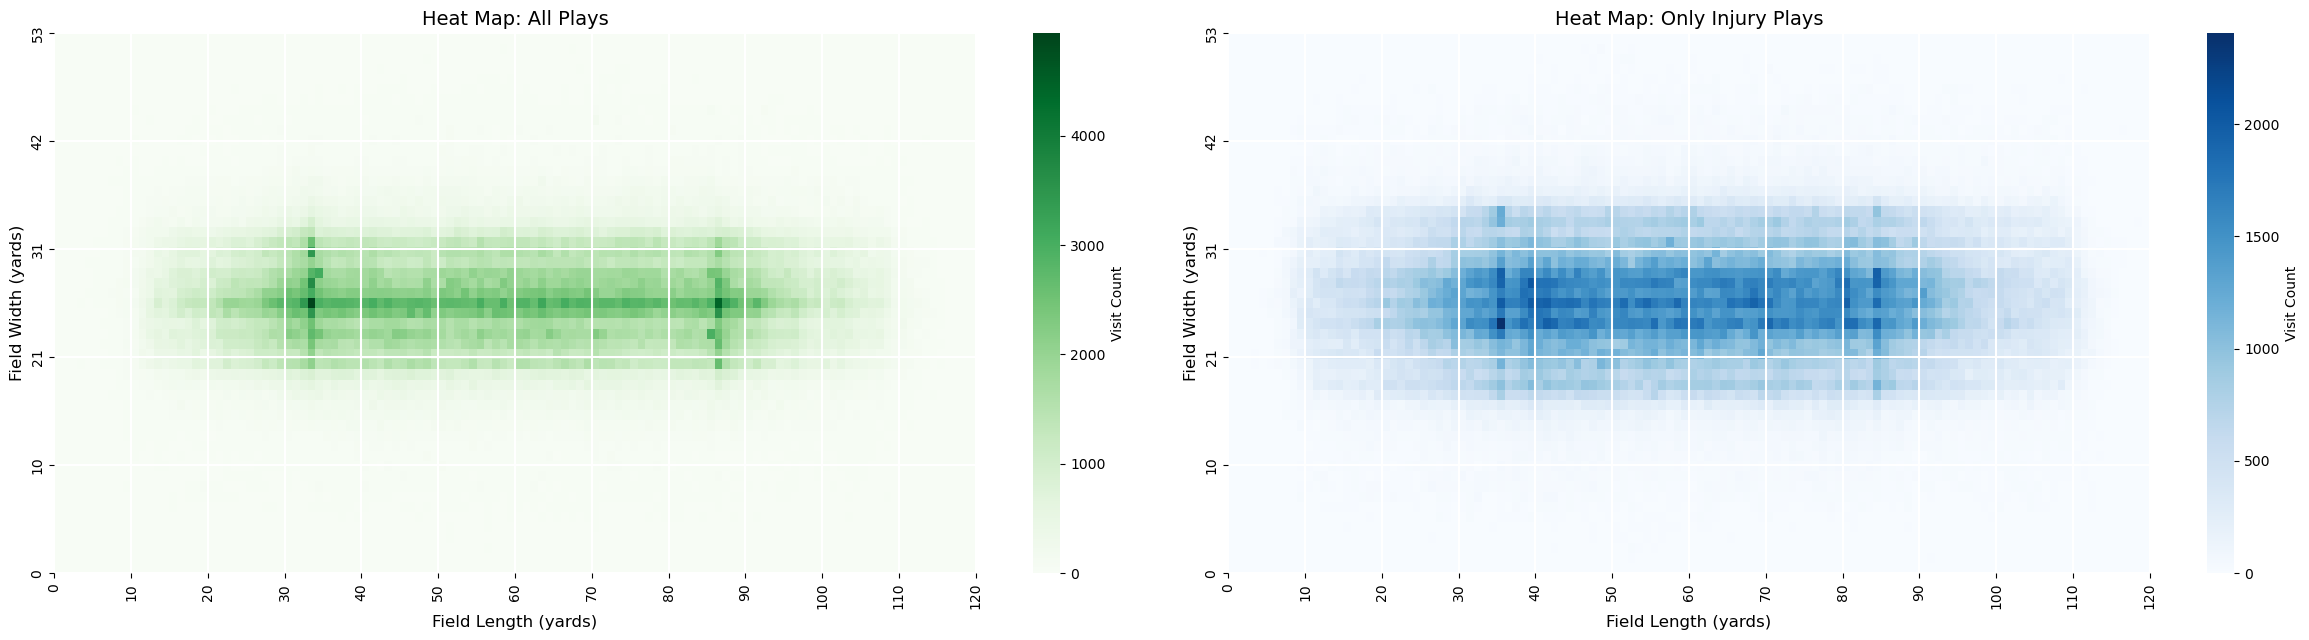

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_field_heatmap_w_subplots(
    ngs_df,
    xbins=120,
    ybins=53,
    annotate=False,
    cmap="Greens",
    ax=None
):
    """
    Heatmap of the football field (120×53.3 yards) with green turf and white yard lines.
    ngs_df must have 'x' (0–120) and 'y' (0–53.3) in yards.
    If ax is None, creates its own figure/axes; otherwise draws on the provided ax.
    """
    # compute 2D histogram
    heat, y_edges, x_edges = np.histogram2d(
        ngs_df['y'], ngs_df['x'],
        bins=[ybins, xbins],
        range=[[0, 53.3], [0, 120]]
    )

    # if no axes passed, create one
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6.5))
        created_fig = True

    sns.heatmap(
        heat,
        cmap=cmap,
        cbar_kws={'label': 'Visit Count'},
        annot=annotate,
        fmt='.0f',
        ax=ax
    )
    ax.invert_yaxis()

    # white yard lines every 10 yards
    x_ticks = np.linspace(0, xbins, 13)
    y_ticks = np.linspace(0, ybins, 6)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
    ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)
    ax.grid(which='major', color='white', linewidth=1.5)
    ax.grid(which='minor', visible=False)

    ax.set_xlabel('Field Length (yards)', fontsize=12)
    ax.set_ylabel('Field Width (yards)', fontsize=12)

    if created_fig:
        ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
        plt.tight_layout()
        plt.show()

    return ax
# === USAGE EXAMPLE WITH TWO DATAFRAMES SIDE BY SIDE ===

# assume df1 and df2 are your two NGS dataframes:
fig, axes = plt.subplots(1, 2, figsize=(24, 6.5))

# left heatmap
visualize_field_heatmap_w_subplots(
    ngs_df=ol_weeks,
    annotate=False,
    cmap="Greens",
    ax=axes[0]
)
axes[0].set_title("Heat Map: All Plays", fontsize=14)

# right heatmap
visualize_field_heatmap_w_subplots(
    ngs_df=dl_weeks,
    annotate=False,
    cmap="Blues",
    ax=axes[1]
)
axes[1].set_title("Heat Map: Only Injury Plays", fontsize=14)

plt.tight_layout()
plt.show()

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def visualize_field_heatmap_with_motion(player_df, xbins=120, ybins=53):
    """
    Draws a heatmap of field occupancy and overlays motion vectors with OL position labels.
    """
    # 1. Create bin edges
    x_edges = np.linspace(0, 120, xbins + 1)
    y_edges = np.linspace(0, 53.3, ybins + 1)
    hmap = np.zeros((xbins, ybins))

    # 2. Populate heatmap grid
    for i in range(xbins):
        for j in range(ybins):
            hmap[i, j] = len(
                player_df[
                    (player_df.x >= x_edges[i]) & (player_df.x < x_edges[i + 1]) &
                    (player_df.y >= y_edges[j]) & (player_df.y < y_edges[j + 1])
                ]
            )

    # 3. Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 6.5))
    sns.heatmap(
        np.transpose(hmap),
        cmap="YlOrRd",
        ax=ax,
        cbar=True,
        xticklabels=False,
        yticklabels=False
    )

    # 4. Axis ticks and labels
    xticks = np.arange(0, 121, 10)
    yticks = np.arange(0, 54, 9)

    ax.set_xticks(np.linspace(0, xbins, len(xticks)))
    ax.set_xticklabels(xticks)

    ax.set_yticks(np.linspace(0, ybins, len(yticks)))
    ax.set_yticklabels(yticks)

    ax.set_xlabel("Field Length (yards)")
    ax.set_ylabel("Field Width (yards)")
    ax.set_title("Player Field Heatmap + Motion Flow + Position Labels", fontsize=16)

    # 5. Compute motion vectors per player
    motion_df = (
        player_df
        .sort_values(['gameId', 'playId', 'nflId', 'frameId'])
        .groupby(['gameId', 'playId', 'nflId'])
        .agg({
            'x': ['first', 'last'],
            'y': ['first', 'last'],
            'officialPosition': 'first'
        })
        .reset_index()
    )
    motion_df.columns = ['gameId', 'playId', 'nflId', 'x_start', 'x_end', 'y_start', 'y_end', 'officialPosition']
    motion_df['dx'] = motion_df['x_end'] - motion_df['x_start']
    motion_df['dy'] = motion_df['y_end'] - motion_df['y_start']
    motion_df['x_mid'] = (motion_df['x_start'] + motion_df['x_end']) / 2
    motion_df['y_mid'] = (motion_df['y_start'] + motion_df['y_end']) / 2

    # 6. Draw motion arrows
    ax.quiver(
        motion_df['x_mid'], motion_df['y_mid'],
        motion_df['dx'], motion_df['dy'],
        color='blue', scale_units='xy', angles='xy', scale=1.5, width=0.0025
    )

    # 7. Label each motion arrow with officialPosition
    for _, row in motion_df.iterrows():
        ax.text(
            row['x_mid'] + 0.5, row['y_mid'] + 0.5,  # slightly offset for visibility
            row['officialPosition'],
            fontsize=8, color='black', weight='bold'
        )

    plt.tight_layout()
    plt.show()


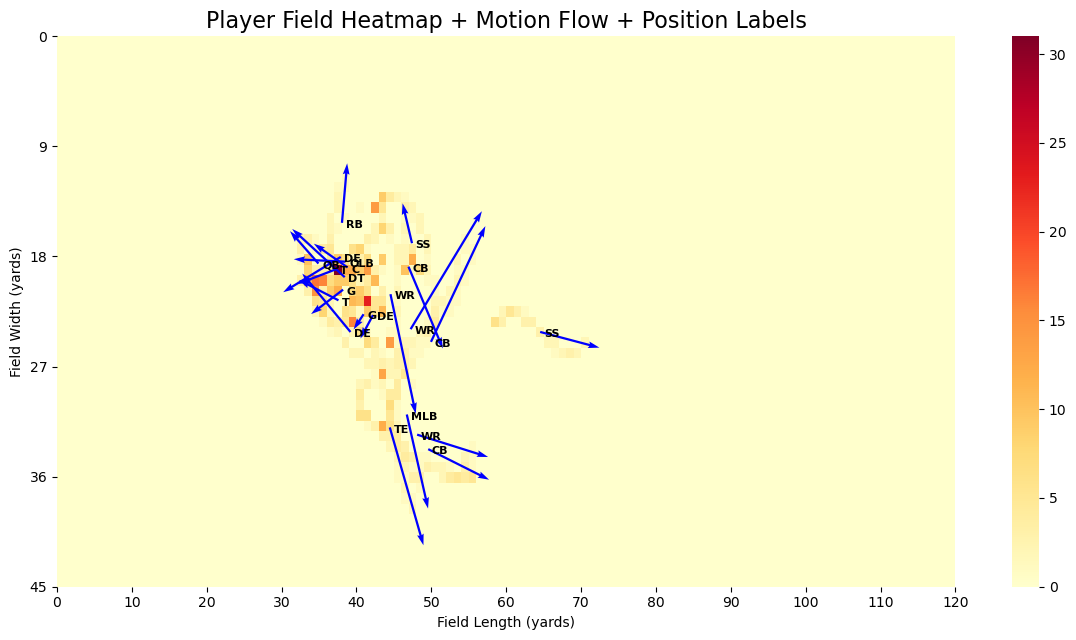

In [53]:
visualize_field_heatmap_with_motion(all_weeks.query("gameId == 2021090900 and playId == 97"))

In [54]:
# set up 

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

# set up dataset
feature_cols = ['s_mean', 's_max', 's_std', 'a_mean', 'a_max', 'a_std', 'x_min',
       'x_max', 'x_mean', 'y_min', 'y_max', 'y_mean', 'defendersInBox', 'absoluteYardlineNumber',
       'pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed',
       'pff_sackAllowed', 'pff_blockType', 'pff_backFieldBlock', 'playResult']

motion_model = motion_df[feature_cols].copy()
motion_model = motion_model.dropna(subset=['pff_blockType', 'pff_backFieldBlock', 'defendersInBox'])

X = motion_model.drop(columns=['playResult'])
y = motion_model['playResult']

X = pd.get_dummies(X, columns=['pff_blockType'], drop_first=True, dtype='int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
X.head()

,s_mean,s_max,s_std,a_mean,a_max,a_std,x_min,x_max,x_mean,y_min,...,pff_blockType_CL,pff_blockType_NB,pff_blockType_PA,pff_blockType_PP,pff_blockType_PR,pff_blockType_PT,pff_blockType_PU,pff_blockType_SR,pff_blockType_SW,pff_blockType_UP
4,1.868605,3.92,1.126741,1.016279,2.13,0.494017,35.43,42.18,39.601860,20.54,...,0,0,0,0,0,0,0,0,1,0
7,2.122791,3.45,1.115118,1.660233,3.09,0.786010,33.64,41.55,37.477907,23.95,...,0,0,0,1,0,0,0,0,0,0
9,1.250465,1.94,0.635692,1.146512,2.43,0.646245,38.80,41.95,40.205116,25.65,...,0,0,0,1,0,0,0,0,0,0
16,1.759767,2.91,1.015195,1.142326,2.76,0.701695,35.00,41.42,38.853488,22.50,...,0,0,0,0,0,0,0,0,1,0
18,1.817442,3.35,0.991185,1.019535,2.19,0.722723,33.46,41.15,38.343488,20.85,...,0,0,0,1,0,0,0,0,0,0


In [57]:
motion_model.columns

Index(['s_mean', 's_max', 's_std', 'a_mean', 'a_max', 'a_std', 'x_min',
       'x_max', 'x_mean', 'y_min', 'y_max', 'y_mean', 'defendersInBox',
       'absoluteYardlineNumber', 'pff_beatenByDefender', 'pff_hitAllowed',
       'pff_hurryAllowed', 'pff_sackAllowed', 'pff_blockType',
       'pff_backFieldBlock', 'playResult'],
      dtype='object')

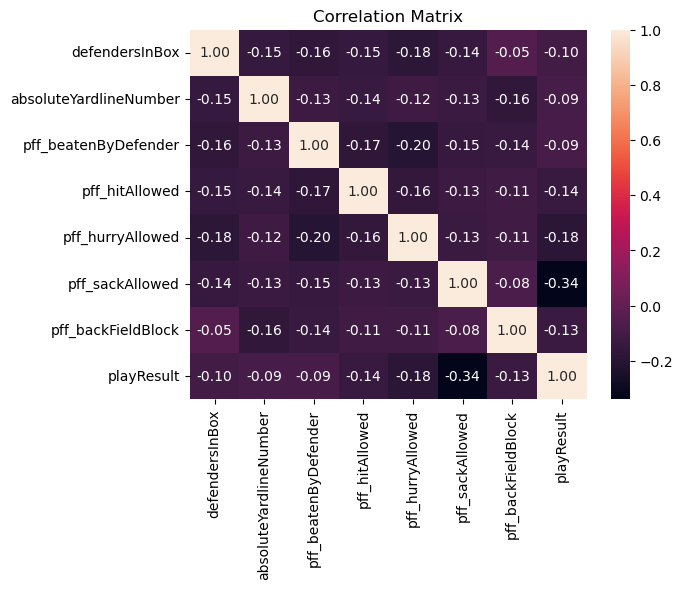

In [58]:
heatmap_cols = ['defendersInBox',
       'absoluteYardlineNumber', 'pff_beatenByDefender', 'pff_hitAllowed',
       'pff_hurryAllowed', 'pff_sackAllowed',
       'pff_backFieldBlock', 'playResult']

heatmap_df = motion_model[heatmap_cols].corr()

sns.heatmap(heatmap_df.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

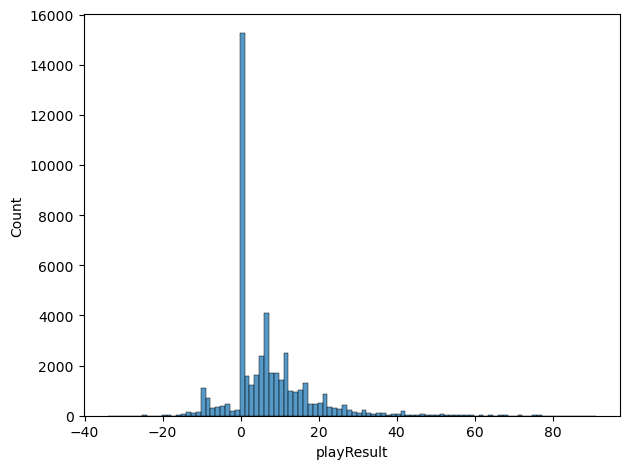

In [59]:
sns.histplot(motion_model['playResult'], bins=100)
plt.tight_layout()

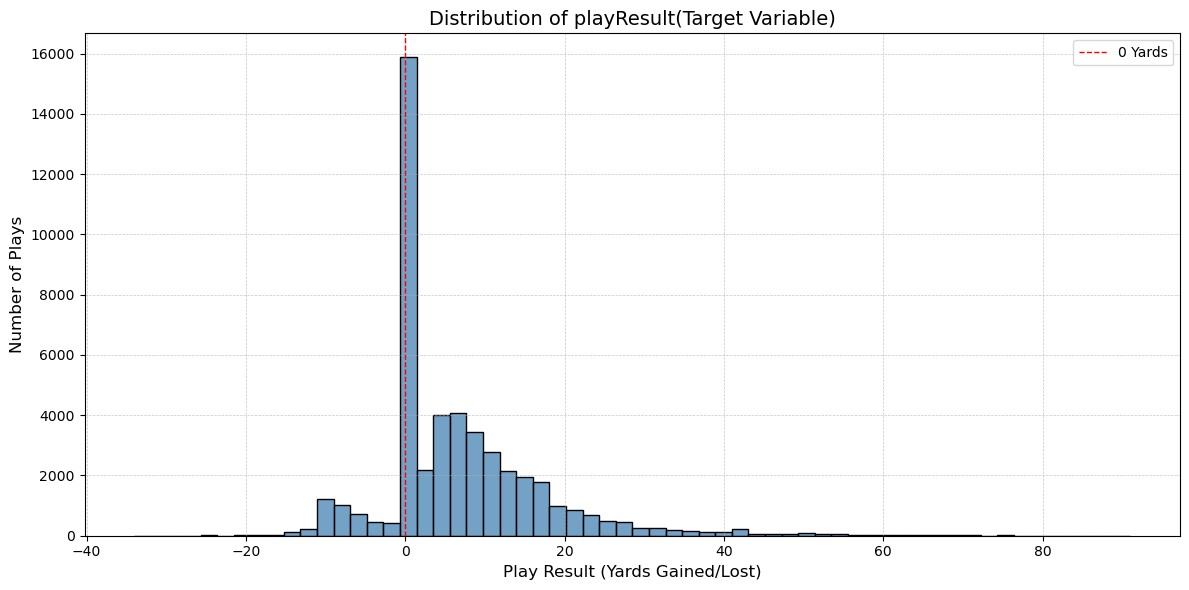

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))  # Make the plot wider
sns.histplot(motion_model['playResult'], bins=60, kde=False, color='steelblue', edgecolor='black')

# Add vertical line at 0 for reference
plt.axvline(0, color='red', linestyle='--', linewidth=1, label='0 Yards')

# Axis labels and title
plt.xlabel('Play Result (Yards Gained/Lost)', fontsize=12)
plt.ylabel('Number of Plays', fontsize=12)
plt.title('Distribution of playResult(Target Variable)', fontsize=14)

# Tweak tick marks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.legend()
plt.tight_layout()
plt.show()

In [61]:
percentage_zero_playResult = (len(motion_model.query('playResult == 0')) / len(motion_model)) * 100
print(f"Percentage of motion_model where playResult == 0: {percentage_zero_playResult:.2f}%")

Percentage of motion_model where playResult == 0: 31.87%


In [62]:
play_results = motion_model['playResult'].value_counts()

percent = len(motion_model) / len(motion_model.query('playResult == 0'))
percent

3.1380802517702597

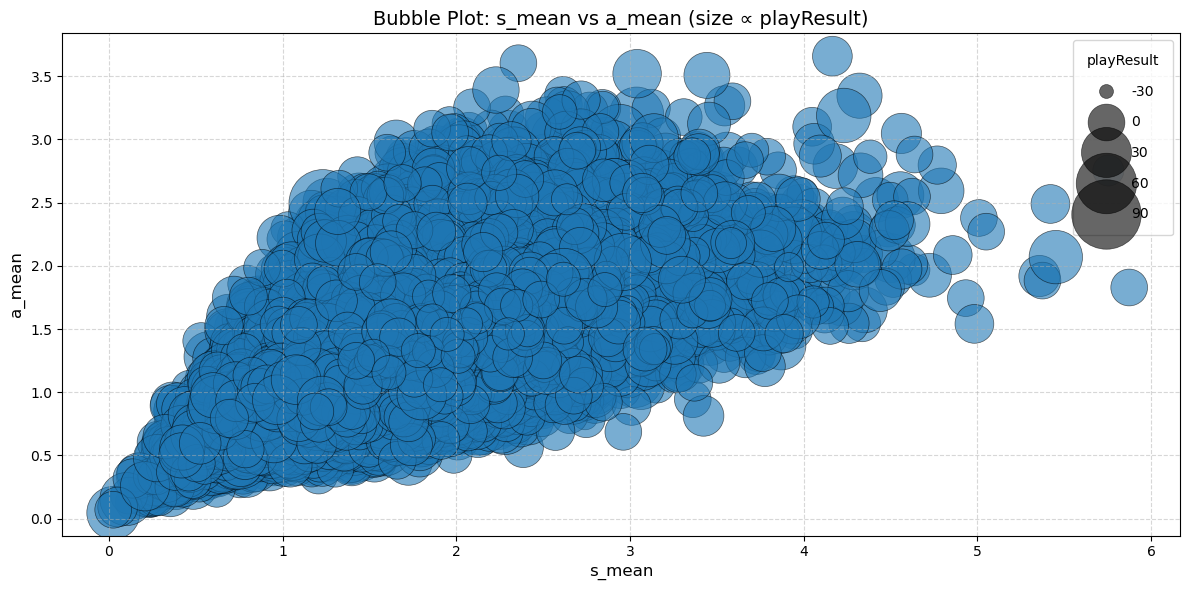

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

motion_model_bubble = motion_model.copy()
x_col = 's_mean'
y_col = 'a_mean'
size_col = 'playResult'

# shift to positive & scale up
min_val = motion_model_bubble[size_col].min()
bubble_sizes = (motion_model_bubble[size_col] - min_val + 1) * 20

plt.figure(figsize=(12, 6))

# after you do plt.scatter(...), capture the PathCollection:
sc = plt.scatter(
    motion_model_bubble[x_col],
    motion_model_bubble[y_col],
    s=bubble_sizes,
    alpha=0.6,
    marker='o',
    edgecolors='k',
    linewidths=0.5,
    color='C0',
)

# legend_elements with func to invert your sizing, fmt to round
handles, labels = sc.legend_elements(
    prop="sizes",
    num=4,
    func=lambda s: (s / 20 + min_val - 1),
    fmt="{x:.0f}"
)

plt.legend(
    handles, 
    labels,
    title=size_col,
    loc="upper right",
    labelspacing=1.2,
    borderpad=1
)

plt.title('Bubble Plot: s_mean vs a_mean (size ∝ playResult)', fontsize=14)
plt.xlabel('s_mean', fontsize=12)
plt.ylabel('a_mean', fontsize=12)
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

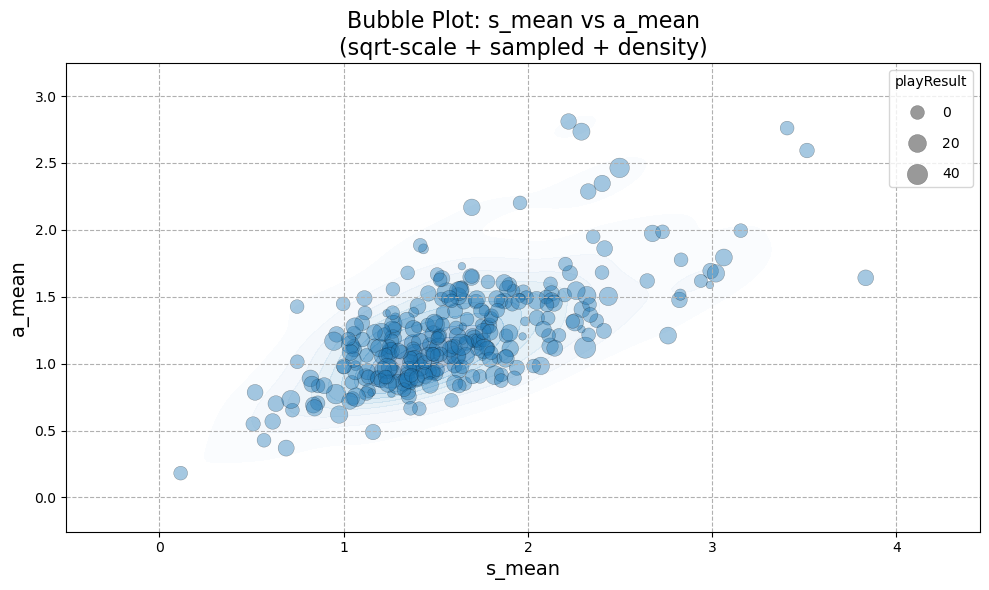

In [64]:
# 1) COPY & SAMPLE to declutter
motion_model_bubble = motion_model.copy()
sample = motion_model_bubble.sample(300, random_state=42)

# 2) CONFIGURE COLUMN NAMES
x_col = 's_mean'
y_col = 'a_mean'
size_col = 'playResult'

# 3) PREPARE SQRT‑SCALED BUBBLE SIZES
min_val = sample[size_col].min()
bubble_sizes = np.sqrt(sample[size_col] - min_val + 1) * 30

# 4) PLOT DENSITY BACKGROUND (optional)
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=sample[x_col],
    y=sample[y_col],
    cmap="Blues",
    fill=True,
    thresh=0.05,
    alpha=0.3
)

# 5) PLOT BUBBLE SCATTER
sc = plt.scatter(
    sample[x_col],
    sample[y_col],
    s=bubble_sizes,
    alpha=0.4,
    c='C0',
    marker='o',
    edgecolors='k',
    linewidths=0.3
)

# 6) ADD SIZE LEGEND (reverse sqrt scale)
handles, labels = sc.legend_elements(
    prop="sizes",
    num=4,
    func=lambda s: ((s/30)**2 + min_val - 1),
    fmt="{x:.0f}"
)
plt.legend(
    handles,
    labels,
    title=size_col,
    loc="upper right",
    labelspacing=1.2
)

# 7) FINAL STYLING
plt.title('Bubble Plot: s_mean vs a_mean\n(sqrt‑scale + sampled + density)', fontsize=16)
plt.xlabel(x_col, fontsize=14)
plt.ylabel(y_col, fontsize=14)
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

In [65]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47862 entries, 4 to 188249
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   s_mean                  47862 non-null  float64
 1   s_max                   47862 non-null  float64
 2   s_std                   47862 non-null  float64
 3   a_mean                  47862 non-null  float64
 4   a_max                   47862 non-null  float64
 5   a_std                   47862 non-null  float64
 6   x_min                   47862 non-null  float64
 7   x_max                   47862 non-null  float64
 8   x_mean                  47862 non-null  float64
 9   y_min                   47862 non-null  float64
 10  y_max                   47862 non-null  float64
 11  y_mean                  47862 non-null  float64
 12  defendersInBox          47862 non-null  float64
 13  absoluteYardlineNumber  47862 non-null  float64
 14  pff_beatenByDefender    47862 non-null  fl

In [66]:
motion_model.head(1000).to_csv('motion_model.csv', index=False)

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# 1. Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Fit PCA with all components
pca = PCA()
pca.fit(X_scaled)

# 3. Compute cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_)

# 4. Find the first index where cumulative variance ≥ 0.80
n_components_80 = np.argmax(cumvar >= 0.80) + 1

print(f"{n_components_80} components are needed to capture ≥ 80% of the variance")
print(f"Cumulative variance at {n_components_80} components: {cumvar[n_components_80-1]:.4f} ({cumvar[n_components_80-1]*100:.1f}%)")

13 components are needed to capture ≥ 80% of the variance
Cumulative variance at 13 components: 0.8004 (80.0%)


In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2 score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R^2 score: 0.0208
Mean Squared Error: 111.3174


In [69]:
# Get feature importances (coefficients)
feature_importance = model.coef_

# Match back to feature names
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values(by='importance', key=abs, ascending=False)

print(importance_df)

                   feature  importance
7                    x_max  -12.084225
8                   x_mean    6.545830
6                    x_min    5.873748
10                   y_max   -1.751530
9                    y_min    1.719707
22        pff_blockType_PA    1.180421
17         pff_sackAllowed   -1.134029
0                   s_mean    0.947565
23        pff_blockType_PP    0.780716
25        pff_blockType_PT    0.587578
1                    s_max   -0.565657
19        pff_blockType_CH    0.559077
20        pff_blockType_CL    0.477579
28        pff_blockType_SW    0.460051
29        pff_blockType_UP    0.411549
2                    s_std    0.390392
16        pff_hurryAllowed   -0.305857
13  absoluteYardlineNumber   -0.242787
21        pff_blockType_NB    0.241564
27        pff_blockType_SR    0.186471
5                    a_std    0.185740
18      pff_backFieldBlock    0.165400
12          defendersInBox   -0.162234
15          pff_hitAllowed   -0.161733
26        pff_blockType_P

In [70]:
# Week 8-style feature correlation/comparison
columns = X.columns
results = []

for i, col_target in enumerate(columns):
    best_score = -np.inf
    best_predictor = None
    
    # Loop through all other columns as predictors
    for col_predictor in columns:
        if col_target == col_predictor:
            continue  # don't predict a feature from itself
        
        # Predictor column must be reshaped into 2D
        X_single = X[[col_predictor]]  # make it a dataframe, not a series
        y_single = X[col_target]
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X_single, y_single)
        
        preds = model.predict(X_single)
        
        # Compute R^2 score (or you could use correlation coefficient if you want)
        score = r2_score(y_single, preds)
        
        if score > best_score:
            best_score = score
            best_predictor = col_predictor
    
    # Save the best predictor for this target feature
    results.append({
        'Target Feature': col_target,
        'Best Predictor': best_predictor,
        'Best R^2 Score': best_score
    })

# Compile results into a dataframe
summary_df = pd.DataFrame(results)
summary_df


,Target Feature,Best Predictor,Best R^2 Score
0,s_mean,s_max,0.761495
1,s_max,s_std,0.902235
2,s_std,s_max,0.902235
3,a_mean,a_std,0.684124
4,a_max,a_std,0.891780
5,a_std,a_max,0.891780
6,x_min,x_mean,0.997213
7,x_max,x_mean,0.997261
8,x_mean,x_max,0.997261
9,y_min,y_mean,0.867063


In [71]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest R^2 score: {r2_rf:.4f}")
print(f"Random Forest Mean Squared Error: {mse_rf:.4f}")
# Get feature importances
feature_importance_rf = rf.feature_importances_
importance_df_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance_rf
}).sort_values(by='importance', ascending=False)
print(importance_df_rf)

Random Forest R^2 score: 0.0579
Random Forest Mean Squared Error: 107.1064
                   feature  importance
0                   s_mean    0.081913
3                   a_mean    0.081070
2                    s_std    0.080118
5                    a_std    0.074759
7                    x_max    0.070519
6                    x_min    0.069772
10                   y_max    0.069580
4                    a_max    0.068446
1                    s_max    0.067854
9                    y_min    0.067603
8                   x_mean    0.063300
13  absoluteYardlineNumber    0.060618
11                  y_mean    0.058588
12          defendersInBox    0.028874
17         pff_sackAllowed    0.012497
28        pff_blockType_SW    0.005560
23        pff_blockType_PP    0.005515
25        pff_blockType_PT    0.005409
14    pff_beatenByDefender    0.005058
20        pff_blockType_CL    0.004666
21        pff_blockType_NB    0.003193
22        pff_blockType_PA    0.003176
16        pff_hurryAllowed  

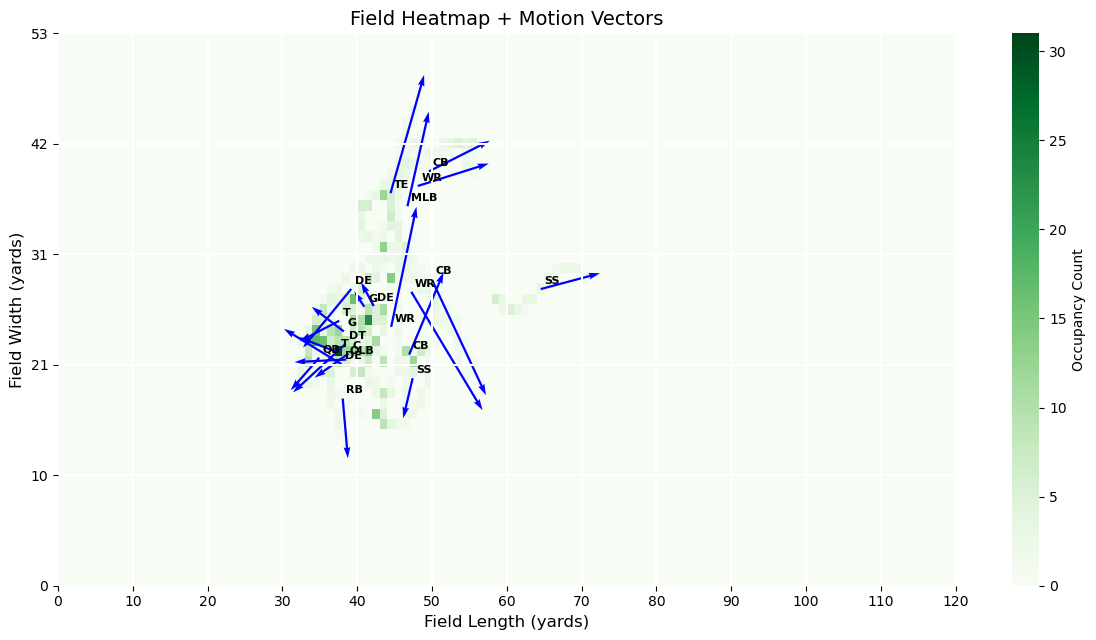

<Axes: title={'center': 'Field Heatmap + Motion Vectors'}, xlabel='Field Length (yards)', ylabel='Field Width (yards)'>

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_field_heatmap_with_motion(
    player_df,
    xbins=120,
    ybins=53,
    cmap="Greens",
    ax=None
):
    """
    Heatmap of the football field (120×53.3 yards) with motion vectors and position labels.
    
    player_df must have columns: 'x', 'y', 'gameId', 'playId', 'nflId', 'frameId', 'officialPosition'.
    If ax is None, creates its own figure/axes; otherwise draws on the provided ax.
    """
    # 1. Compute 2D histogram
    heat, y_edges, x_edges = np.histogram2d(
        player_df['y'], player_df['x'],
        bins=[ybins, xbins],
        range=[[0, 53.3], [0, 120]]
    )
    
    # 2. Create axes if needed
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6.5))
        created_fig = True

    # 3. Draw turf heatmap
    sns.heatmap(
        heat,
        cmap=cmap,
        cbar_kws={'label': 'Occupancy Count'},
        xticklabels=False,
        yticklabels=False,
        ax=ax
    )
    ax.invert_yaxis()

    # 4. Yard‐line grid and labels
    x_ticks = np.linspace(0, xbins, 13)      # 0,10,20,...,120
    y_ticks = np.linspace(0, ybins, 6)       # 0, ~10.66, ... 53.3
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
    ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)
    ax.grid(which='major', color='white', linewidth=1.5)
    ax.grid(which='minor', visible=False)

    ax.set_xlabel('Field Length (yards)', fontsize=12)
    ax.set_ylabel('Field Width (yards)', fontsize=12)
    if created_fig:
        ax.set_title('Field Heatmap + Motion Vectors', fontsize=14)

    # 5. Compute motion vectors per player
    motion_df = (
        player_df
        .sort_values(['gameId', 'playId', 'nflId', 'frameId'])
        .groupby(['gameId', 'playId', 'nflId'])
        .agg({
            'x': ['first', 'last'],
            'y': ['first', 'last'],
            'officialPosition': 'first'
        })
        .reset_index()
    )
    motion_df.columns = [
        'gameId','playId','nflId',
        'x_start','x_end','y_start','y_end','officialPosition'
    ]
    motion_df['dx'] = motion_df['x_end'] - motion_df['x_start']
    motion_df['dy'] = motion_df['y_end'] - motion_df['y_start']
    motion_df['x_mid'] = (motion_df['x_start'] + motion_df['x_end']) / 2
    motion_df['y_mid'] = (motion_df['y_start'] + motion_df['y_end']) / 2

    # 6. Draw arrows
    ax.quiver(
        motion_df['x_mid'], motion_df['y_mid'],
        motion_df['dx'], motion_df['dy'],
        color='blue', scale_units='xy', angles='xy', scale=1.5, width=0.0025
    )

    # 7. Label positions
    for _, row in motion_df.iterrows():
        ax.text(
            row['x_mid'] + 0.5, row['y_mid'] + 0.5,
            row['officialPosition'],
            fontsize=8, color='black', weight='bold'
        )

    if created_fig:
        plt.tight_layout()
        plt.show()

    return ax

visualize_field_heatmap_with_motion(all_weeks.query("gameId == 2021090900 and playId == 97"))

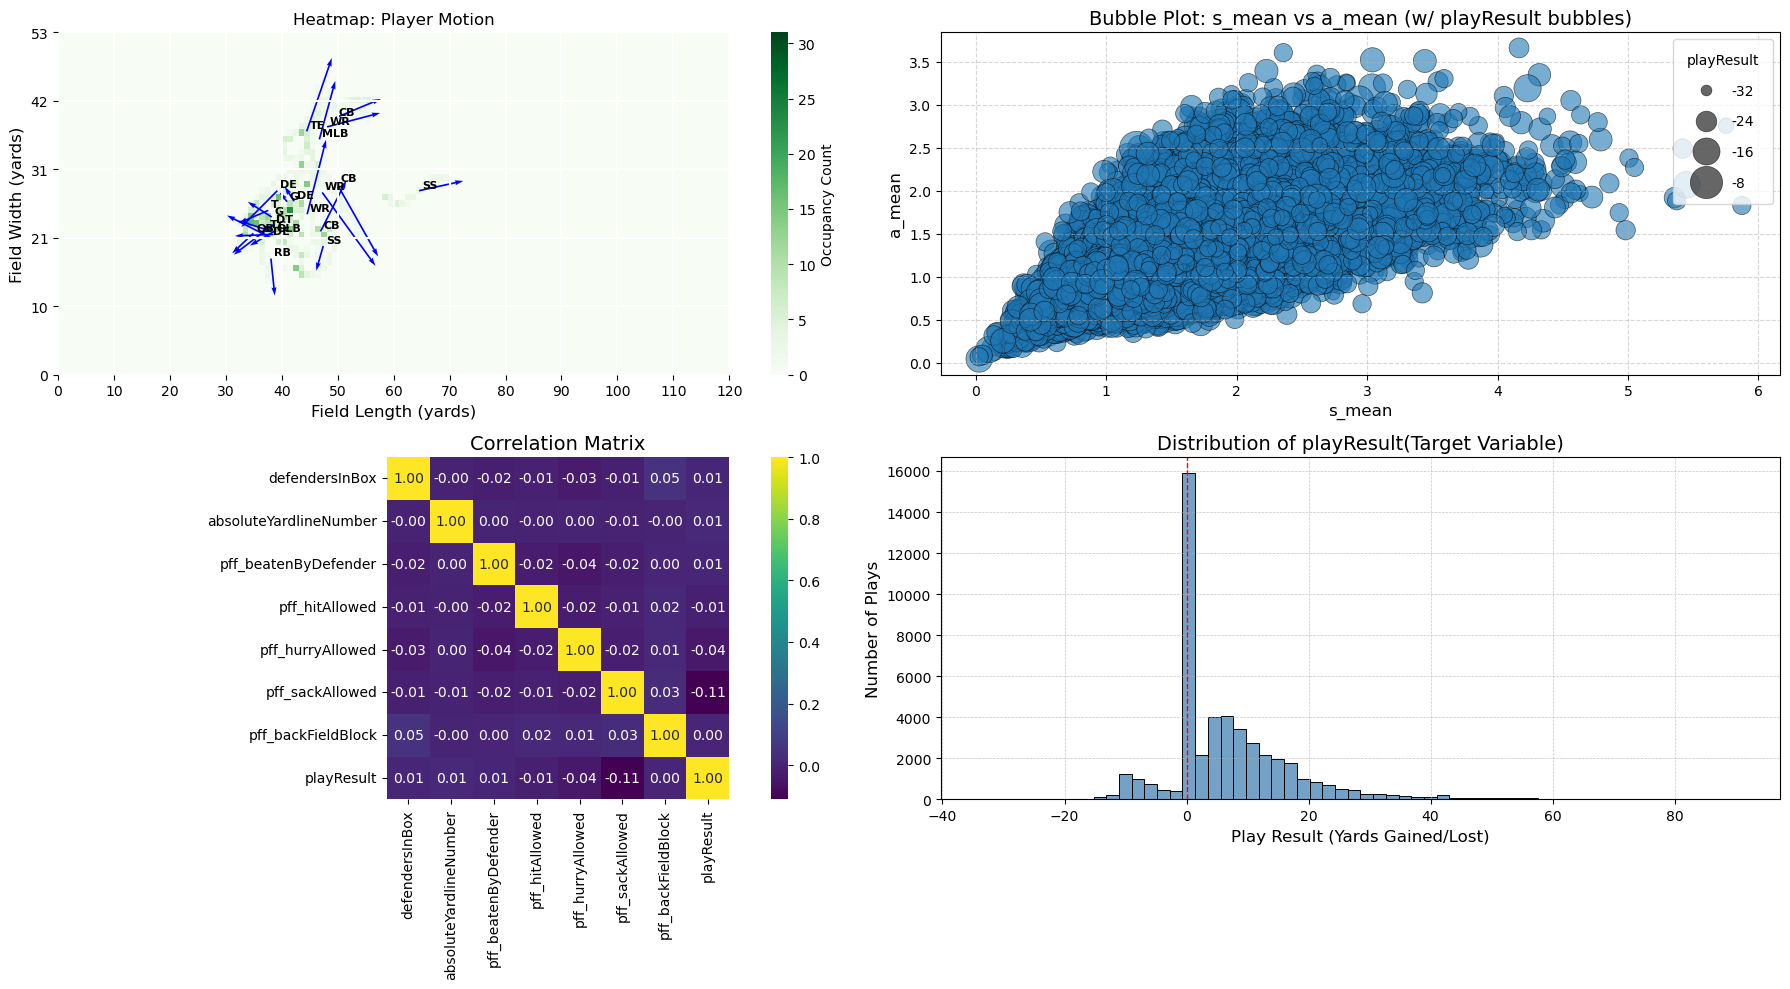

In [95]:
# Set up the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# heatmap
visualize_field_heatmap_with_motion(all_weeks.query("gameId == 2021090900 and playId == 97"), ax= axes[0,0])
axes[0,0].set_title('Heatmap: Player Motion')

# bubble plot
def plot_motion_model_bubble(ax, motion_model):
    motion_model_bubble = motion_model.copy()
    x_col = 's_mean'
    y_col = 'a_mean'
    size_col = 'playResult'

    # Shift to positive & scale up for better bubble visibility
    min_val = motion_model_bubble[size_col].min()
    bubble_sizes = (motion_model_bubble[size_col] - min_val + 1) * 5

    # Plot the scatter inside the subplot `ax`
    sc = ax.scatter(
        motion_model_bubble[x_col],
        motion_model_bubble[y_col],
        s=bubble_sizes,
        alpha=0.6,
        marker='o',
        edgecolors='k',
        linewidths=0.5,
        color='C0',
    )

    # Add bubble size legend
    handles, labels = sc.legend_elements(
        prop="sizes",
        num=4,
        func=lambda s: (s / 20 + min_val - 1),
        fmt="{x:.0f}"
    )

    ax.legend(
        handles,
        labels,
        title=size_col,
        loc="upper right",
        labelspacing=1.2,
        borderpad=1
    )

    ax.set_title('Bubble Plot: s_mean vs a_mean (w/ playResult bubbles)', fontsize=14)
    ax.set_xlabel('s_mean', fontsize=12)
    ax.set_ylabel('a_mean', fontsize=12)
    ax.grid(linestyle='--', alpha=0.5)

# Bubble plot into the first subplot
plot_motion_model_bubble(axes[0, 1], motion_model)

def plot_correlation_matrix(ax, motion_model):
    heatmap_cols = [
        'defendersInBox', 'absoluteYardlineNumber',
        'pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed',
        'pff_sackAllowed', 'pff_backFieldBlock', 'playResult'
    ]
    
    heatmap_df = motion_model[heatmap_cols].corr()

    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        cbar=True,
        square=True,
        ax=ax
    )

    ax.set_title('Correlation Matrix', fontsize=14)

# Use one subplot for the correlation matrix
plot_correlation_matrix(axes[1, 0], motion_model)


# target variable visualization
sns.histplot(motion_model['playResult'], bins=60, kde=False, color='steelblue', edgecolor='black', ax=axes[1,1])

# Add vertical line at 0 for reference
axes[1,1].axvline(0, color='red', linestyle='--', linewidth=1, label='0 Yards')

# Axis labels and title
axes[1,1].set_xlabel('Play Result (Yards Gained/Lost)', fontsize=12)
axes[1,1].set_ylabel('Number of Plays', fontsize=12)
axes[1,1].set_title('Distribution of playResult(Target Variable)', fontsize=14)

# Show grid for better readability
axes[1,1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()
